# Analysis of animal re-identification datasets

This notebook shows some basic characteristics of the datasets extracted from the dataframes or metadata.

In [1]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from wildlife_datasets import datasets, loader

root_dataset = '/data/wildlife_datasets/data'
root_dataframe = '/data/wildlife_datasets/dataframes'

datasets_ignore = ['SeaTurtleIDHeads']
dataset_names = [dataset_name for dataset_name in datasets.names_all]
dataset_names = [dataset_name for dataset_name in datasets.names_all 
                    if 'Segmented' not in dataset_name.__name__
                        and dataset_name.__name__ not in datasets_ignore
                ]

ds = loader.load_datasets(dataset_names, root_dataset, root_dataframe)
ds_meta = loader.load_datasets([datasets.AnimalCLEF2025, datasets.AnimalCLEF2026, datasets.WildlifeReID10k], root_dataset, root_dataframe)

Resolving data files:   0%|          | 0/46 [00:00<?, ?it/s]

The number of published datasets steadily increases throughout the years.

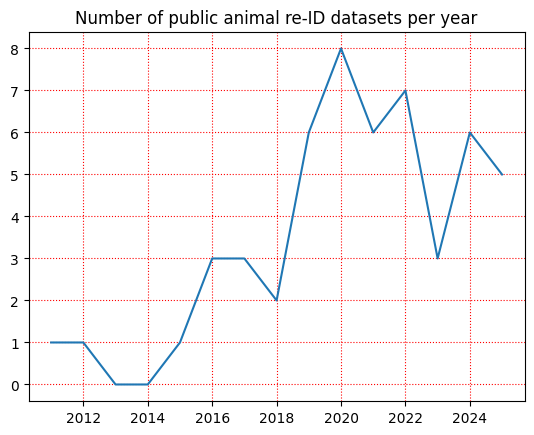

In [2]:
years = np.array([d.summary['year'] for d in ds])
years_range = range(min(years), max(years)+1)
counts = [sum(year == years) for year in years_range]

plt.plot(years_range, counts)
plt.title('Number of public animal re-ID datasets per year');
plt.grid(which='major', color='r', linestyle=':')

The next code shows a summary of each dataset with the publication year, number of images and individuals and other information.

In [3]:
def number_individuals(df):
    identities = df['identity'].unique()
    if 'unknown' in list(identities):
        return len(identities)-1
    else:
        return len(identities)

def number_images(df):
    return sum(df['identity'] != 'unknown')

def number_species(df):
    return df['species'].count() if 'species' in df.columns else 1

def create_dict(i, meta=False):
    return {
        'species': i.summary['animals_simple'],
        'year': i.summary['year'],
        '$n_{\\rm img}$': number_images(i.df),
        '$n_{\\rm ind}$': number_individuals(i.df),
        'span': i.summary['span'],
        'source': 'video' if i.summary['from_video'] else 'photo',
        'pose': i.summary['pose'],
        'timestamp': 'date' in i.df.columns,
        'wild': i.summary['wild'],
        'more species': number_species(i.df) > 1,
        'size (MB)': int(i.summary['size']) if not pd.isnull(i.summary['size']) else 0
    }

def convert_latex(df, ds, add_citations=True):    
    df = df.copy()
    if add_citations:
        cites = [r' \cite{' + d.summary['cite'] + '}' for d in ds]
        df.insert(loc=0, column = 'name', value=df.index+cites)
    else:
        df.insert(loc=0, column = 'name', value=df.index)
    df.replace(True, r'\cmark', inplace=True)
    df.replace(False, r'\xmark', inplace=True)
    return df.to_latex(index=False, escape=False, float_format="%.0f")

In [4]:
names = [d.display_name() for d in ds_meta]
df_meta = pd.DataFrame([create_dict(d) for d in ds_meta], index=names)
df_print = df_meta.copy()
df_print.replace(True, "\u2714", inplace=True)
df_print.replace(False, "\u2716", inplace=True)
df_print

,species,year,$n_{\rm img}$,$n_{\rm ind}$,span,source,pose,timestamp,wild,more species,size (MB)
AnimalCLEF2025,multiple,2025,15209,1233,very long,photo,multiple,✔,✔,✔,1930
AnimalCLEF2026,multiple,2026,15483,1450,very long,photo,multiple,✔,✔,✔,2080
WildlifeReID10k,multiple,2024,140488,10772,very long,photo,multiple,✔,✔,✔,24760


In [5]:
names = [d.display_name() for d in ds]
df = pd.DataFrame([create_dict(d) for d in ds], index=names)
df_print = df.copy()
df_print.replace(True, "\u2714", inplace=True)
df_print.replace(False, "\u2716", inplace=True)
df_print

,species,year,$n_{\rm img}$,$n_{\rm ind}$,span,source,pose,timestamp,wild,more species,size (MB)
AAUZebraFish,fish,2020,6672,6,1 day,video,double,✖,✖,✖,12093
AerialCattle2017,cows,2017,46340,23,1 day,video,single,✖,✖,✖,724
AmvrakikosTurtles,sea turtles,2024,200,50,4.4 years,photo,double,✔,✔,✖,1870
ATRW,tigers,2019,5415,182,short,video,double,✖,✖,✖,1760
BalearicLizard,lizards,2025,4619,1009,15 years,photo,single,✔,✖,✖,36450
BelugaID,whales,2022,8559,788,2.1 years,photo,single,✔,✔,✔,590
BirdIndividualID,birds,2019,51934,50,15 days,photo,single,✔,✖,✔,70656
BristolGorillas2020,gorillas,2020,5594,7,short,video,single,✖,✖,✖,15600
CattleMuzzle,cows,2021,2899,300,short,video,single,✖,✖,✖,17600
CatIndividualImages,cats,2020,13021,509,short,photo,multiple,✖,✖,✖,11000


In [6]:
print(convert_latex(df_meta, ds_meta))

\begin{tabular}{llrrrllllllr}
\toprule
name & species & year & $n_{\rm img}$ & $n_{\rm ind}$ & span & source & pose & timestamp & wild & more species & size (MB) \\
\midrule
AnimalCLEF2025 \cite{adam2025overview} & multiple & 2025 & 15209 & 1233 & very long & photo & multiple & \cmark & \cmark & \cmark & 1930 \\
AnimalCLEF2026 \cite{} & multiple & 2026 & 15483 & 1450 & very long & photo & multiple & \cmark & \cmark & \cmark & 2080 \\
WildlifeReID10k \cite{adam} & multiple & 2024 & 140488 & 10772 & very long & photo & multiple & \cmark & \cmark & \cmark & 24760 \\
\bottomrule
\end{tabular}



In [7]:
print(convert_latex(df, ds))

\begin{tabular}{llrrrllllllr}
\toprule
name & species & year & $n_{\rm img}$ & $n_{\rm ind}$ & span & source & pose & timestamp & wild & more species & size (MB) \\
\midrule
AAUZebraFish \cite{bruslund2020re} & fish & 2020 & 6672 & 6 & 1 day & video & double & \xmark & \xmark & \xmark & 12093 \\
AerialCattle2017 \cite{andrew2017visual} & cows & 2017 & 46340 & 23 & 1 day & video & single & \xmark & \xmark & \xmark & 724 \\
AmvrakikosTurtles \cite{adam2024exploiting} & sea turtles & 2024 & 200 & 50 & 4.4 years & photo & double & \cmark & \cmark & \xmark & 1870 \\
ATRW \cite{li2019atrw} & tigers & 2019 & 5415 & 182 & short & video & double & \xmark & \xmark & \xmark & 1760 \\
BalearicLizard \cite{alcaraz2025rematch} & lizards & 2025 & 4619 & 1009 & 15 years & photo & single & \cmark & \xmark & \xmark & 36450 \\
BelugaID \cite{belugaid} & whales & 2022 & 8559 & 788 & 2.1 years & photo & single & \cmark & \cmark & \cmark & 590 \\
BirdIndividualID \cite{ferreira2020deep} & birds & 2019 & 519